In [1]:
%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.inversion as inv 

from antarctic_plots import utils, regions, maps, fetch, utils, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import matplotlib.pyplot as plt
import pygmt
# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()
%load_ext snakeviz

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
surface = "inversion_layers/bedmachine_surface.nc"
icebase = "inversion_layers/bedmachine_icebase.nc"
bed_bedmachine = "inversion_layers/bedmachine_bed.nc"
bed_bedmap2 = "inversion_layers/bedmap2_bed.nc"

# TODO update RIS_bathymetry_data.ipynb to reproduce the below:
bed_riggs = 'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc'

# not sure, think below is just standard bedmap2 bed
# bed_regional = 'bathymetry_data/bedmap2_bed_regional.nc'

basement_bedmachine = "inversion_layers/bed_basement_merged.nc"
basement_ANTASed = "inversion_layers/ANTASed_magnetics_merged_basement.nc"

#  Setup inversion and layers

In [3]:
# polygon = regions.draw_region()

In [4]:
# starting_region = utils.polygon_to_region(polygon)

filtering and resampling ice from 1000m to 10000m


c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


filtering and resampling water from 1000m to 10000m
filtering and resampling bathymetry from 1000m to 10000m
ice: 19600 points, elevations:3700m to 0m
water: 19600 points, elevations:3698m to -2866m
bathymetry: 19600 points, elevations:3698m to -4063m
gravity: 5356 points
gravity avg. elevation: 1000
bathymetry control points:10475932


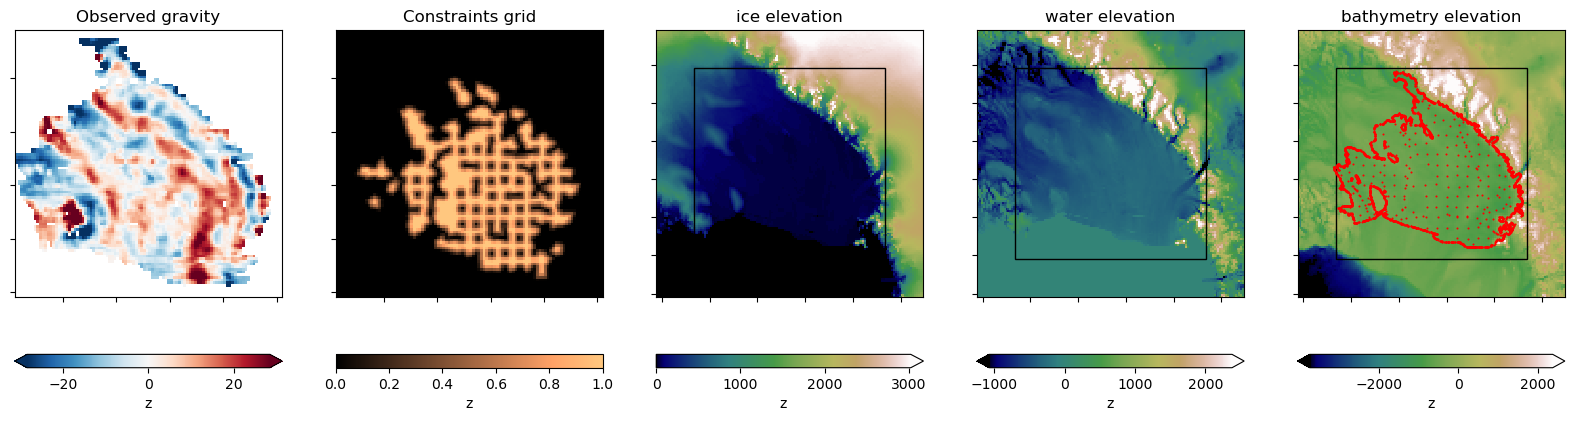

In [5]:
# starting inversion region is 1,000km x 1,000km, choose whether to zoom in, 
# shift the region to the North or West, or change the width of the buffer zone. 

Bouguer_correction_layers = ["ice"]

# starting_region = [-50e3, 50e3, -800e3, -700e3]
starting_region = [-580000, 420000, -1420000, -420000]

inv_reg, buffer_reg = utils.alter_region(
    starting_region = starting_region,
    zoom = 0,#400e3,
    n_shift = 0,
    w_shift = 0,#100e3,
    buffer = 200e3,
    )

returned = inv.import_layers(
    layers_list = [
        'ice',
        'water',
        'bathymetry',
        # 'basement',
        # 'moho',
        ], 
    spacing_list = [
        10e3,
        10e3,
        10e3,
        10e3,
        20e3,
        ], 
    rho_list = [
        920, #890 to 917 from Muto et al. 2013
        1030, #from Muto et al. 2013
        2300,
        2670,
        3300,
        ],
    fname_list = [
        # SURFACE 
            surface,
        # ICEBASE
            icebase,
        # BED/BATHYMETRY
            bed_bedmachine, # just standard bedmachine bed
            # bed_bedmap2, # just standard bedmap2 bed
            # bed_riggs, # bed with bedmachine outside of RIS, bedmap2 inside of RIS, and RIGGS points within RIS
        # BASEMENT
            basement_bedmachine, # Ross Embayment basement merged to bedmachine bed
            # basement_ANTASed # Ross Embayment basement merged to ANTASed basement
        # MOHO
            'inversion_layers/An_moho_filt.nc',
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc',
        ],
    grav_spacing = 10e3, 
    active_layer='bathymetry',
    buffer_region = buffer_reg,
    inversion_region = inv_reg,

    # Choose between grid and csv, similar comp. times
    # grav_file='gravity_data/rosetta_eq_source_up_continued_Gobs.nc',
    grav_file='gravity_data/rosetta_eq_source_up_continued.csv',
    # grav_file = 'gravity_data/ant4d_gravity_epsg_5k.nc',

    constraints=True,
    constraints_file='constraints_grid/constraints_grid.nc',
    constraints_points='bathymetry_data/bedmachine_RIGGS.csv',
    
    plot=True,
    # plot_type='pygmt',  # 50sec with csv, 53sec with nc
    plot_type='xarray', # 11 sec with csv, 11sec with nc
    plot_region=buffer_reg,
    power_spectrum=False,
    )
layers, grav, grav_spacing, constraints_grid, constraints_df, constraints_RIS_df = returned

# Make prism layers

bathymetry top: -303m and bottom: -4063m
water top: 29m and bottom: -303m
ice top: 831m and bottom: 29m


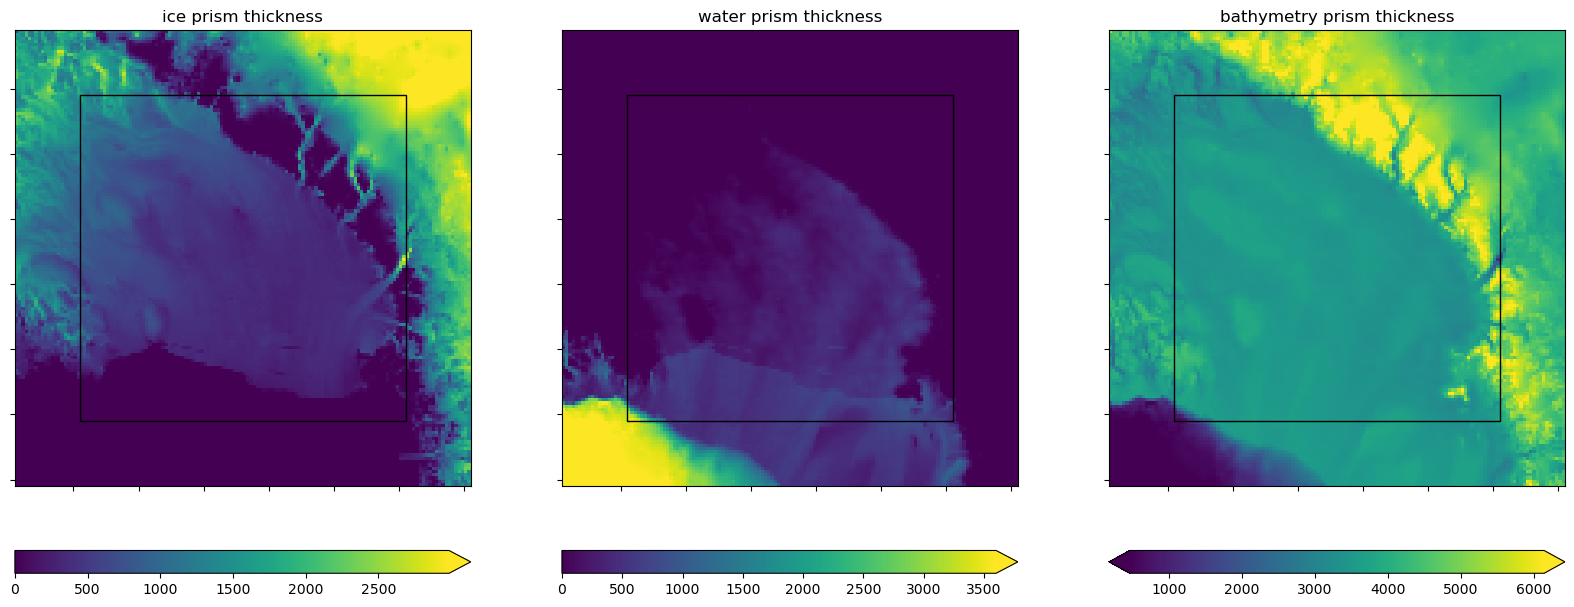

In [6]:
inv.grids_to_prism_layers(
    layers, 
    plot=True, 
    # plot_region=inv_reg,
    plot_type='2D', 
    # plot_type='3D',
    buffer_region = buffer_reg,
    inversion_region = inv_reg,
    ) 

# Forward gravity

In [7]:
# use below 3 lines to calculate forward grav at full grid extent, 
# not just grav observation points
# makes an evenly spaced grid
# grav_grid = utils.make_grid(inv_reg, grav_spacing, 1000, "Gobs")
# grav = vd.grid_to_table(grav_grid).astype('float64')
# grav['z']=1000

df_forward = inv.forward_grav_layers(
    layers, 
    grav,  
    exclude_layers=Bouguer_correction_layers,
    )
df_forward.describe()

using supplied DataFrame for observation points
19600 prisms in ice layer
finished ice layer
19600 prisms in water layer
finished water layer
19600 prisms in bathymetry layer
finished bathymetry layer


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total
count,5356.000000,5.356000e+03,5.356000e+03,5356.0,5.356000e+03,5356.000000,5.356000e+03,5.356000e+03
mean,-95046.209858,-9.827539e+05,3.396171e-16,1000.0,1.698086e-15,0.000000,-4.499927e-15,-4.754640e-15
std,228558.005482,2.047474e+05,1.361468e+01,0.0,7.138494e+00,7.967457,1.357159e+01,1.141384e+01
min,-575000.000000,-1.372500e+06,-7.955864e+01,1000.0,-1.839004e+01,-10.943537,-5.518043e+01,-6.612368e+01
25%,-267500.000000,-1.145000e+06,-7.666919e+00,1000.0,-3.396190e+00,-7.377409,-8.196788e+00,-5.480648e+00
50%,-95000.000000,-9.950000e+05,3.299048e-01,1000.0,-1.470251e+00,-0.269124,-7.253593e-01,5.372261e-01
75%,85000.000000,-8.350000e+05,7.985093e+00,1000.0,3.167717e+00,5.728674,7.053042e+00,5.221067e+00
max,372500.000000,-4.550000e+05,6.998506e+01,1000.0,3.869554e+01,25.540053,1.381845e+02,1.283853e+02


Plots of forward gravity calculations

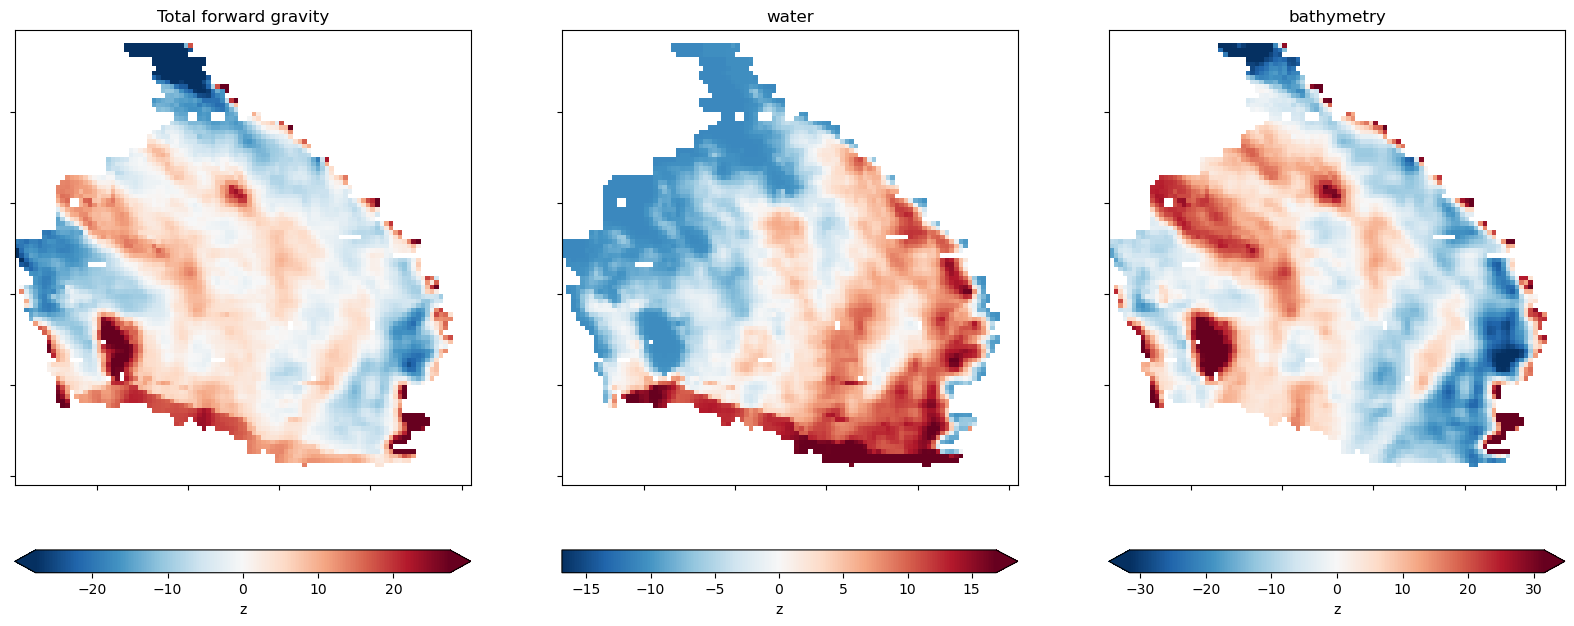

In [8]:
layers, forward_grav_total = inv.forward_grav_plotting(
    df_forward,
    layers,
    inversion_region = inv_reg,
    grav_spacing = grav_spacing,
    # plot_dists = True,
    # plot_power_spectrums = True,
    exclude_layers=Bouguer_correction_layers,
)

Ice forward gravity

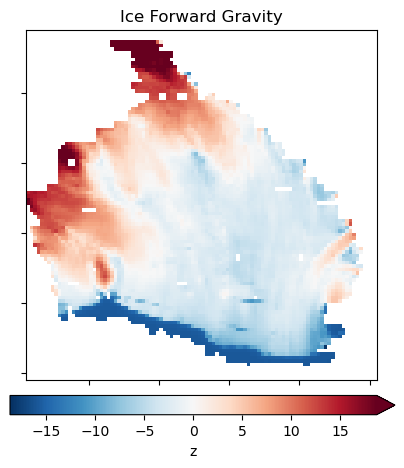

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
layers['ice']['forward_grav_grid'].plot(
    ax=ax,
    x='x',
    y='y',
    robust=True,
    cmap='RdBu_r',
    cbar_kwargs={
        'orientation':'horizontal', 
        'anchor':(1,1), 
        'fraction':0.05, 
        'pad':0.04},
    )
ax.set_title('Ice Forward Gravity')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')

Cross sections

In [10]:
# lines = profile.draw_lines()

In [11]:
# get clicked points
# df = utils.shapes_to_df(lines)
# # extract first and last
# a = (df.x.iloc[0], df.y.iloc[0])
# b = (df.x.iloc[-1], df.y.iloc[-1]) 

In [12]:
# # extract layers for profile plot
# names = []
# topo_grids = []
# forward_grav_grids = []
# for k, v in layers.items():
#     names.append(k)
#     topo_grids.append(v['grid'])
#     forward_grav_grids.append(v['forward_grav_grid'])

# layers_dict = profile.make_data_dict(
#     names = names,
#     grids = topo_grids,
#     colors = ["lightskyblue","darkblue","lightbrown","chocolate", "darkolivegreen"],
# )

# data_dict = profile.make_data_dict(
#     names = names,
#     grids = forward_grav_grids,
#     colors = ["red","blue","purple","black", "magenta"]
#     )

# # add dictionary entry for total forward gravity
# data_dict["total"] = {}
# data_dict["total"]["name"] = "total"
# data_dict["total"]["grid"] = forward_grav_total
# data_dict["total"]["color"] = "forestgreen"

# a = (0, -641024)
# b = (0, -1363968)

# c = (-50e3, -750e3)#(-200e3, -925e3)
# d = (50e3, -750e3)#(200e3, -925e3)

In [13]:
# profile.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     add_map=True,
#     subplot_orientation='horizontal',
#     data_dict=data_dict,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

In [14]:
# profile.plot_profile(
#     "points",
#     start=c,
#     stop=d,
#     num=1000,
#     add_map=True,
#     subplot_orientation='vertical',
#     data_dict=data_dict,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     inset_width=.15,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# Anomalies

## Method 1: Filter

applying bouguer correction for layers: ['ice']
Root mean squared residual: 5.58mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,boug_corr,grav_corrected,misfit,reg,res
count,5356.000000,5.356000e+03,5.356000e+03,5356.0,5.356000e+03,5356.000000,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5356.000000,5356.000000
mean,-95046.209858,-9.827539e+05,3.396171e-16,1000.0,1.698086e-15,0.000000,-4.499927e-15,-4.754640e-15,1.698086e-15,-1.358469e-15,3.056554e-15,0.117279,-0.117279
std,228558.005482,2.047474e+05,1.361468e+01,0.0,7.138494e+00,7.967457,1.357159e+01,1.141384e+01,7.138494e+00,1.668081e+01,1.399380e+01,11.112198,5.580350
min,-575000.000000,-1.372500e+06,-7.955864e+01,1000.0,-1.839004e+01,-10.943537,-5.518043e+01,-6.612368e+01,-1.839004e+01,-1.017077e+02,-1.218511e+02,-60.646729,-81.303010
25%,-267500.000000,-1.145000e+06,-7.666919e+00,1000.0,-3.396190e+00,-7.377409,-8.196788e+00,-5.480648e+00,-3.396190e+00,-8.954765e+00,-7.592098e+00,-6.574921,-2.172105
50%,-95000.000000,-9.950000e+05,3.299048e-01,1000.0,-1.470251e+00,-0.269124,-7.253593e-01,5.372261e-01,-1.470251e+00,2.285197e+00,5.868104e-01,0.080529,0.099919
75%,85000.000000,-8.350000e+05,7.985093e+00,1000.0,3.167717e+00,5.728674,7.053042e+00,5.221067e+00,3.167717e+00,1.049278e+01,8.396330e+00,7.220906,2.347023
max,372500.000000,-4.550000e+05,6.998506e+01,1000.0,3.869554e+01,25.540053,1.381845e+02,1.283853e+02,3.869554e+01,5.839287e+01,5.070861e+01,35.899372,36.262334


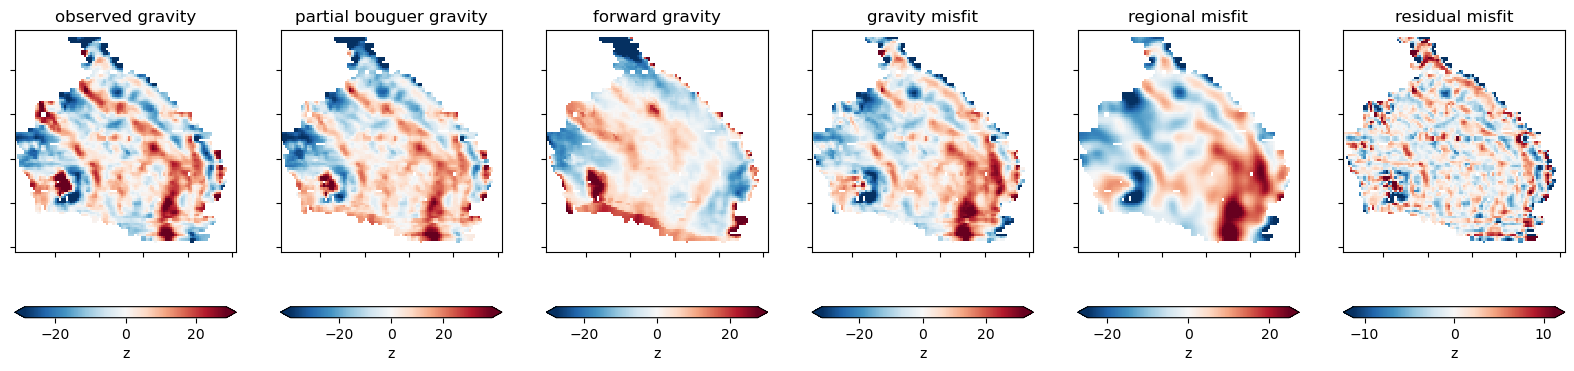

In [39]:
filter='g100e3'
df_anomalies = inv.anomalies(
        layers = layers, 
        input_grav = df_forward, 
        grav_spacing = grav_spacing, 
        regional_method = 'filter', 
        filter=filter,
        inversion_region=inv_reg,
        corrections=Bouguer_correction_layers, 
    )

anom_grids = inv.anomalies_plotting(
    df_anomalies,
    inversion_region = inv_reg,
    grav_spacing = grav_spacing,
    # plot_constraints=True,
    # constraints=constraints_RIS_df,
    # plot_dists=True,
    # plot_power_spectrums=True,
    )

df_anomalies.describe()

## Method 2: Trend

applying bouguer correction for layers: ['ice']
Root mean squared residual: 8.27mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,boug_corr,grav_corrected,misfit,reg,res
count,5356.000000,5.356000e+03,5.356000e+03,5356.0,5.356000e+03,5356.000000,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5356.000000,5356.000000
mean,-95046.209858,-9.827539e+05,3.396171e-16,1000.0,1.698086e-15,0.000000,-4.499927e-15,-4.754640e-15,1.698086e-15,-1.358469e-15,3.056554e-15,-0.074410,0.074410
std,228558.005482,2.047474e+05,1.361468e+01,0.0,7.138494e+00,7.967457,1.357159e+01,1.141384e+01,7.138494e+00,1.668081e+01,1.399380e+01,11.307843,8.268012
min,-575000.000000,-1.372500e+06,-7.955864e+01,1000.0,-1.839004e+01,-10.943537,-5.518043e+01,-6.612368e+01,-1.839004e+01,-1.017077e+02,-1.218511e+02,-67.585995,-90.479174
25%,-267500.000000,-1.145000e+06,-7.666919e+00,1000.0,-3.396190e+00,-7.377409,-8.196788e+00,-5.480648e+00,-3.396190e+00,-8.954765e+00,-7.592098e+00,-6.289421,-4.401963
50%,-95000.000000,-9.950000e+05,3.299048e-01,1000.0,-1.470251e+00,-0.269124,-7.253593e-01,5.372261e-01,-1.470251e+00,2.285197e+00,5.868104e-01,0.585858,0.268275
75%,85000.000000,-8.350000e+05,7.985093e+00,1000.0,3.167717e+00,5.728674,7.053042e+00,5.221067e+00,3.167717e+00,1.049278e+01,8.396330e+00,5.837966,4.739213
max,372500.000000,-4.550000e+05,6.998506e+01,1000.0,3.869554e+01,25.540053,1.381845e+02,1.283853e+02,3.869554e+01,5.839287e+01,5.070861e+01,35.263184,43.812054


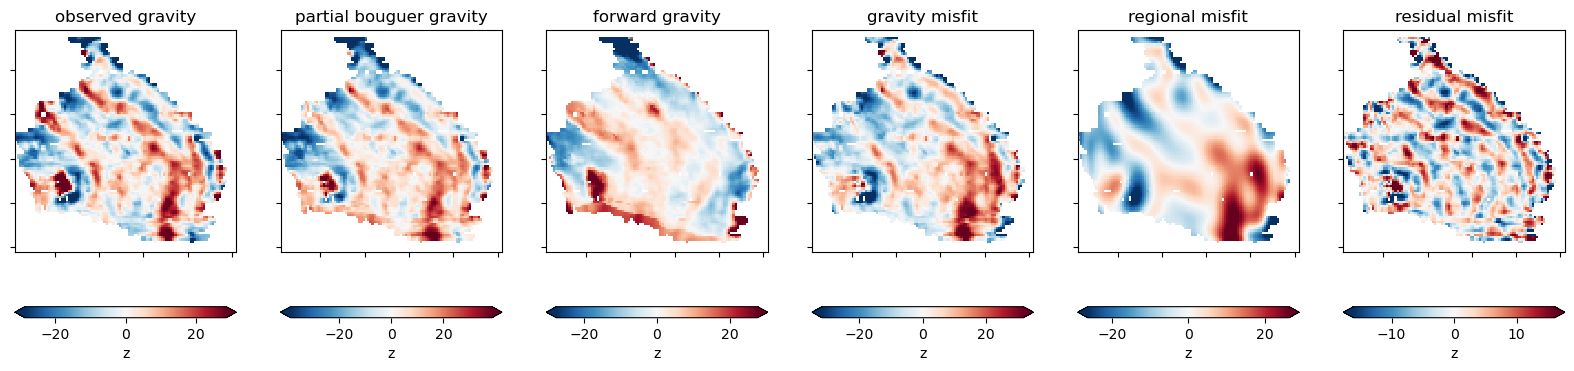

In [37]:
trend=24
df_anomalies = inv.anomalies( 
        layers = layers, 
        input_grav = df_forward, 
        grav_spacing = grav_spacing, 
        regional_method = 'trend', 
        trend=trend,
        inversion_region=inv_reg,
        corrections=Bouguer_correction_layers,
    )

anom_grids = inv.anomalies_plotting(
    df_anomalies,
    inversion_region = inv_reg,
    grav_spacing = grav_spacing,
    # plot_constraints=True,
    # constraints=constraints_RIS_df,
    # plot_dists=True,
    # plot_power_spectrums=True,
    )

df_anomalies.describe()

## Method 3: Constraints

applying bouguer correction for layers: ['ice']
Root mean squared residual: 5.34mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,boug_corr,grav_corrected,misfit,reg,res
count,5356.000000,5.356000e+03,5.356000e+03,5356.0,5.356000e+03,5356.000000,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5356.000000,5356.000000
mean,-95046.209858,-9.827539e+05,3.396171e-16,1000.0,1.698086e-15,0.000000,-4.499927e-15,-4.754640e-15,1.698086e-15,-1.358469e-15,3.056554e-15,0.215449,-0.215449
std,228558.005482,2.047474e+05,1.361468e+01,0.0,7.138494e+00,7.967457,1.357159e+01,1.141384e+01,7.138494e+00,1.668081e+01,1.399380e+01,13.353053,5.336392
min,-575000.000000,-1.372500e+06,-7.955864e+01,1000.0,-1.839004e+01,-10.943537,-5.518043e+01,-6.612368e+01,-1.839004e+01,-1.017077e+02,-1.218511e+02,-104.436823,-65.977636
25%,-267500.000000,-1.145000e+06,-7.666919e+00,1000.0,-3.396190e+00,-7.377409,-8.196788e+00,-5.480648e+00,-3.396190e+00,-8.954765e+00,-7.592098e+00,-7.217629,-2.411990
50%,-95000.000000,-9.950000e+05,3.299048e-01,1000.0,-1.470251e+00,-0.269124,-7.253593e-01,5.372261e-01,-1.470251e+00,2.285197e+00,5.868104e-01,0.622261,-0.144594
75%,85000.000000,-8.350000e+05,7.985093e+00,1000.0,3.167717e+00,5.728674,7.053042e+00,5.221067e+00,3.167717e+00,1.049278e+01,8.396330e+00,8.986198,2.070159
max,372500.000000,-4.550000e+05,6.998506e+01,1000.0,3.869554e+01,25.540053,1.381845e+02,1.283853e+02,3.869554e+01,5.839287e+01,5.070861e+01,47.803486,30.208191


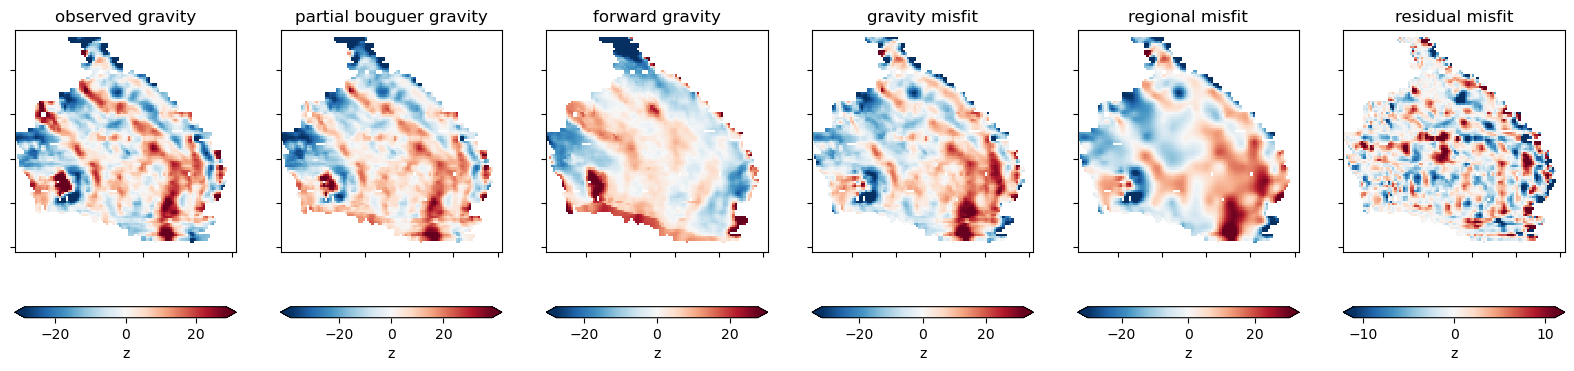

In [60]:
constraints=constraints_df
df_anomalies = inv.anomalies(
        layers = layers, 
        input_grav = df_forward, 
        grav_spacing = grav_spacing, 
        regional_method = 'constraints', 
        constraints=constraints,
        inversion_region=inv_reg,
        corrections=Bouguer_correction_layers, 
        )

anom_grids = inv.anomalies_plotting(
    df_anomalies,
    inversion_region = inv_reg,
    grav_spacing = grav_spacing,
    # plot_constraints=True,
    # constraints=constraints_RIS_df,
    # plot_dists=True,
    # plot_power_spectrums=True,
    )     
df_anomalies.describe()

## Method 4: Equivalent sources

applying bouguer correction for layers: ['ice']
Root mean squared residual: 5.87mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,boug_corr,grav_corrected,misfit,reg,res
count,5356.000000,5.356000e+03,5.356000e+03,5356.0,5.356000e+03,5356.000000,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5.356000e+03,5356.000000,5356.000000
mean,-95046.209858,-9.827539e+05,3.396171e-16,1000.0,1.698086e-15,0.000000,-4.499927e-15,-4.754640e-15,1.698086e-15,-1.358469e-15,3.056554e-15,-0.134196,0.134196
std,228558.005482,2.047474e+05,1.361468e+01,0.0,7.138494e+00,7.967457,1.357159e+01,1.141384e+01,7.138494e+00,1.668081e+01,1.399380e+01,13.495953,5.865394
min,-575000.000000,-1.372500e+06,-7.955864e+01,1000.0,-1.839004e+01,-10.943537,-5.518043e+01,-6.612368e+01,-1.839004e+01,-1.017077e+02,-1.218511e+02,-124.475586,-61.445483
25%,-267500.000000,-1.145000e+06,-7.666919e+00,1000.0,-3.396190e+00,-7.377409,-8.196788e+00,-5.480648e+00,-3.396190e+00,-8.954765e+00,-7.592098e+00,-7.640625,-2.997673
50%,-95000.000000,-9.950000e+05,3.299048e-01,1000.0,-1.470251e+00,-0.269124,-7.253593e-01,5.372261e-01,-1.470251e+00,2.285197e+00,5.868104e-01,0.230042,0.089288
75%,85000.000000,-8.350000e+05,7.985093e+00,1000.0,3.167717e+00,5.728674,7.053042e+00,5.221067e+00,3.167717e+00,1.049278e+01,8.396330e+00,8.283966,3.268069
max,372500.000000,-4.550000e+05,6.998506e+01,1000.0,3.869554e+01,25.540053,1.381845e+02,1.283853e+02,3.869554e+01,5.839287e+01,5.070861e+01,49.063232,31.933815


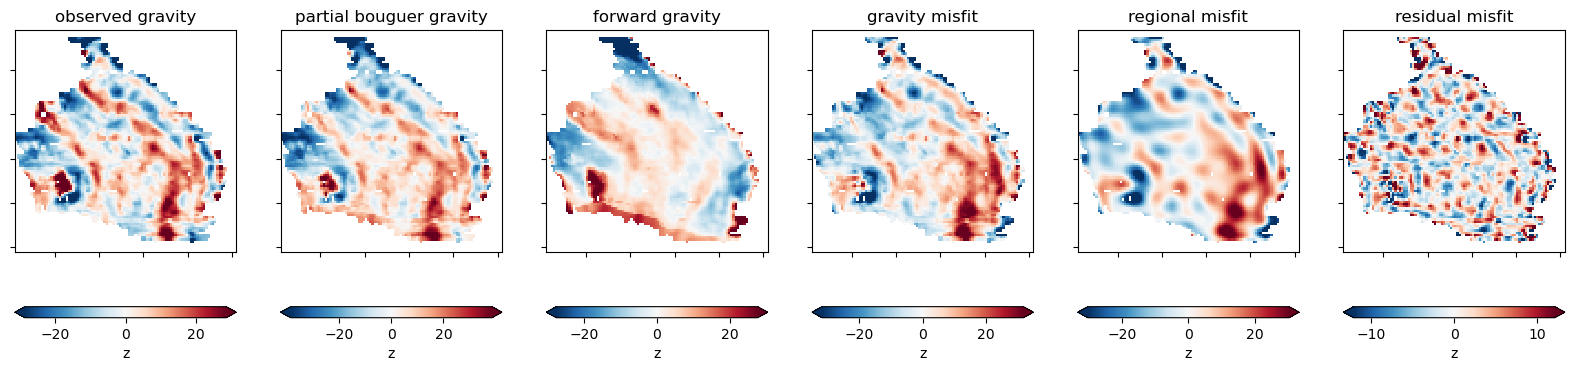

In [53]:
eq_sources=500e3
df_anomalies = inv.anomalies(
        layers = layers, 
        input_grav = df_forward, 
        grav_spacing = grav_spacing, 
        regional_method = 'eq_sources', 
        eq_sources=eq_sources,
        depth_type='relative',
        damping=None,
        block_size=grav_spacing,
        inversion_region=inv_reg,
        corrections=Bouguer_correction_layers, 
        )

anom_grids = inv.anomalies_plotting(
    df_anomalies,
    inversion_region = inv_reg,
    grav_spacing = grav_spacing,
    # plot_constraints=True,
    # constraints=constraints_RIS_df,
    # plot_dists=True,
    # plot_power_spectrums=True,
    )     
df_anomalies.describe()

In [16]:
# anomalies_dict = profile.make_data_dict(
#     names = ["Observed", "Bouguer", "Forward total", "Misfit", "Regional misfit", "Residual misfit"],
#     grids = anom_grids,
#     colors = ["black", "turquoise", "red", "purple", "forestgreen", "blue"]
#     )

# keys = ["Observed", "Bouguer"] # The keys you want
# subset0 = dict((k, anomalies_dict[k]) for k in keys if k in anomalies_dict)

# keys = ["Bouguer", "Forward total", "Misfit",] # The keys you want
# subset1 = dict((k, anomalies_dict[k]) for k in keys if k in anomalies_dict)

# keys = ["Misfit", "Regional misfit", "Residual misfit"] # The keys you want
# subset2 = dict((k, anomalies_dict[k]) for k in keys if k in anomalies_dict)

# a = (0, -641024)
# b = (0, -1363968)

# c = (-50e3, -750e3)#(-200e3, -925e3)
# d = (50e3, -750e3)#(200e3, -925e3)

In [17]:
# profile.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     add_map=True,
#     subplot_orientation='horizontal',
#     data_dict=subset0,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# profile.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     add_map=True,
#     subplot_orientation='horizontal',
#     data_dict=subset1,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# profile.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     add_map=True,
#     subplot_orientation='horizontal',
#     data_dict=subset2,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# just the data
# profile.plot_data(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     data_dict=subset2,
#     share_yaxis=True,
# )

In [18]:
# profile.plot_profile(
#     "points",
#     start=c,
#     stop=d,
#     num=1000,
#     add_map=True,
#     subplot_orientation='vertical',
#     data_dict=subset0,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     inset_width=.15,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# profile.plot_profile(
#     "points",
#     start=c,
#     stop=d,
#     num=1000,
#     add_map=True,
#     subplot_orientation='vertical',
#     data_dict=subset1,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     inset_width=.15,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# profile.plot_profile(
#     "points",
#     start=c,
#     stop=d,
#     num=1000,
#     add_map=True,
#     subplot_orientation='vertical',
#     data_dict=subset2,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     inset_width=.15,
#     map_points=constraints_RIS_df,
#     data_height=5,
# )

# Geo inversion

In [57]:
# %%snakeviz --new-tab
# regional_method='filter'
# regional_method='trend'
# regional_method='constraints'
regional_method = 'eq_sources'

topo_results, grav_results = inv.geo_inversion(
    active_layer='bathymetry',
    layers=layers, 
    input_grav=df_anomalies, 
    regional_method = regional_method,
    Max_Iterations=3,
    deriv_type='prisms',
    solver_type='least squares',
    max_layer_change_per_iter=100,

    apply_constraints = False,
    constraints_grid=constraints_grid,
    corrections=Bouguer_correction_layers, # layers to exclude

    filter=filter, 
    trend=trend,
    constraints=constraints_df,
    eq_sources=eq_sources,
    depth_type='relative',
    damping=None,
    block_size=grav_spacing,

    inversion_region = inv_reg,
    buffer_region=buffer_reg,
    grav_spacing = grav_spacing,

    # save_results = True,
    # fname_topo = "topo_results_5k_constraints_base",
    # fname_gravity = "gravity_results_5k_constraints_base",
    ) 

notify
# 17 secs for least squares

##################################
iteration 1
initial RMS residual = 5.87mGal
RMS layer correction 28.6m
constraints not applied
calculating updated forward gravity
updating the misfits
applying bouguer correction for layers: ['ice']
Root mean squared residual: 4.47mGal
##################################
iteration 2
initial RMS residual = 4.47mGal
RMS layer correction 24.93m
constraints not applied
calculating updated forward gravity
updating the misfits
applying bouguer correction for layers: ['ice']
Root mean squared residual: 3.13mGal
##################################
iteration 3
initial RMS residual = 3.13mGal
RMS layer correction 17.75m
constraints not applied
calculating updated forward gravity
updating the misfits
applying bouguer correction for layers: ['ice']
Root mean squared residual: 2.25mGal
Inversion terminated after 3 iterations with least-squares norm=5 because maximum number of iterations (3) reached


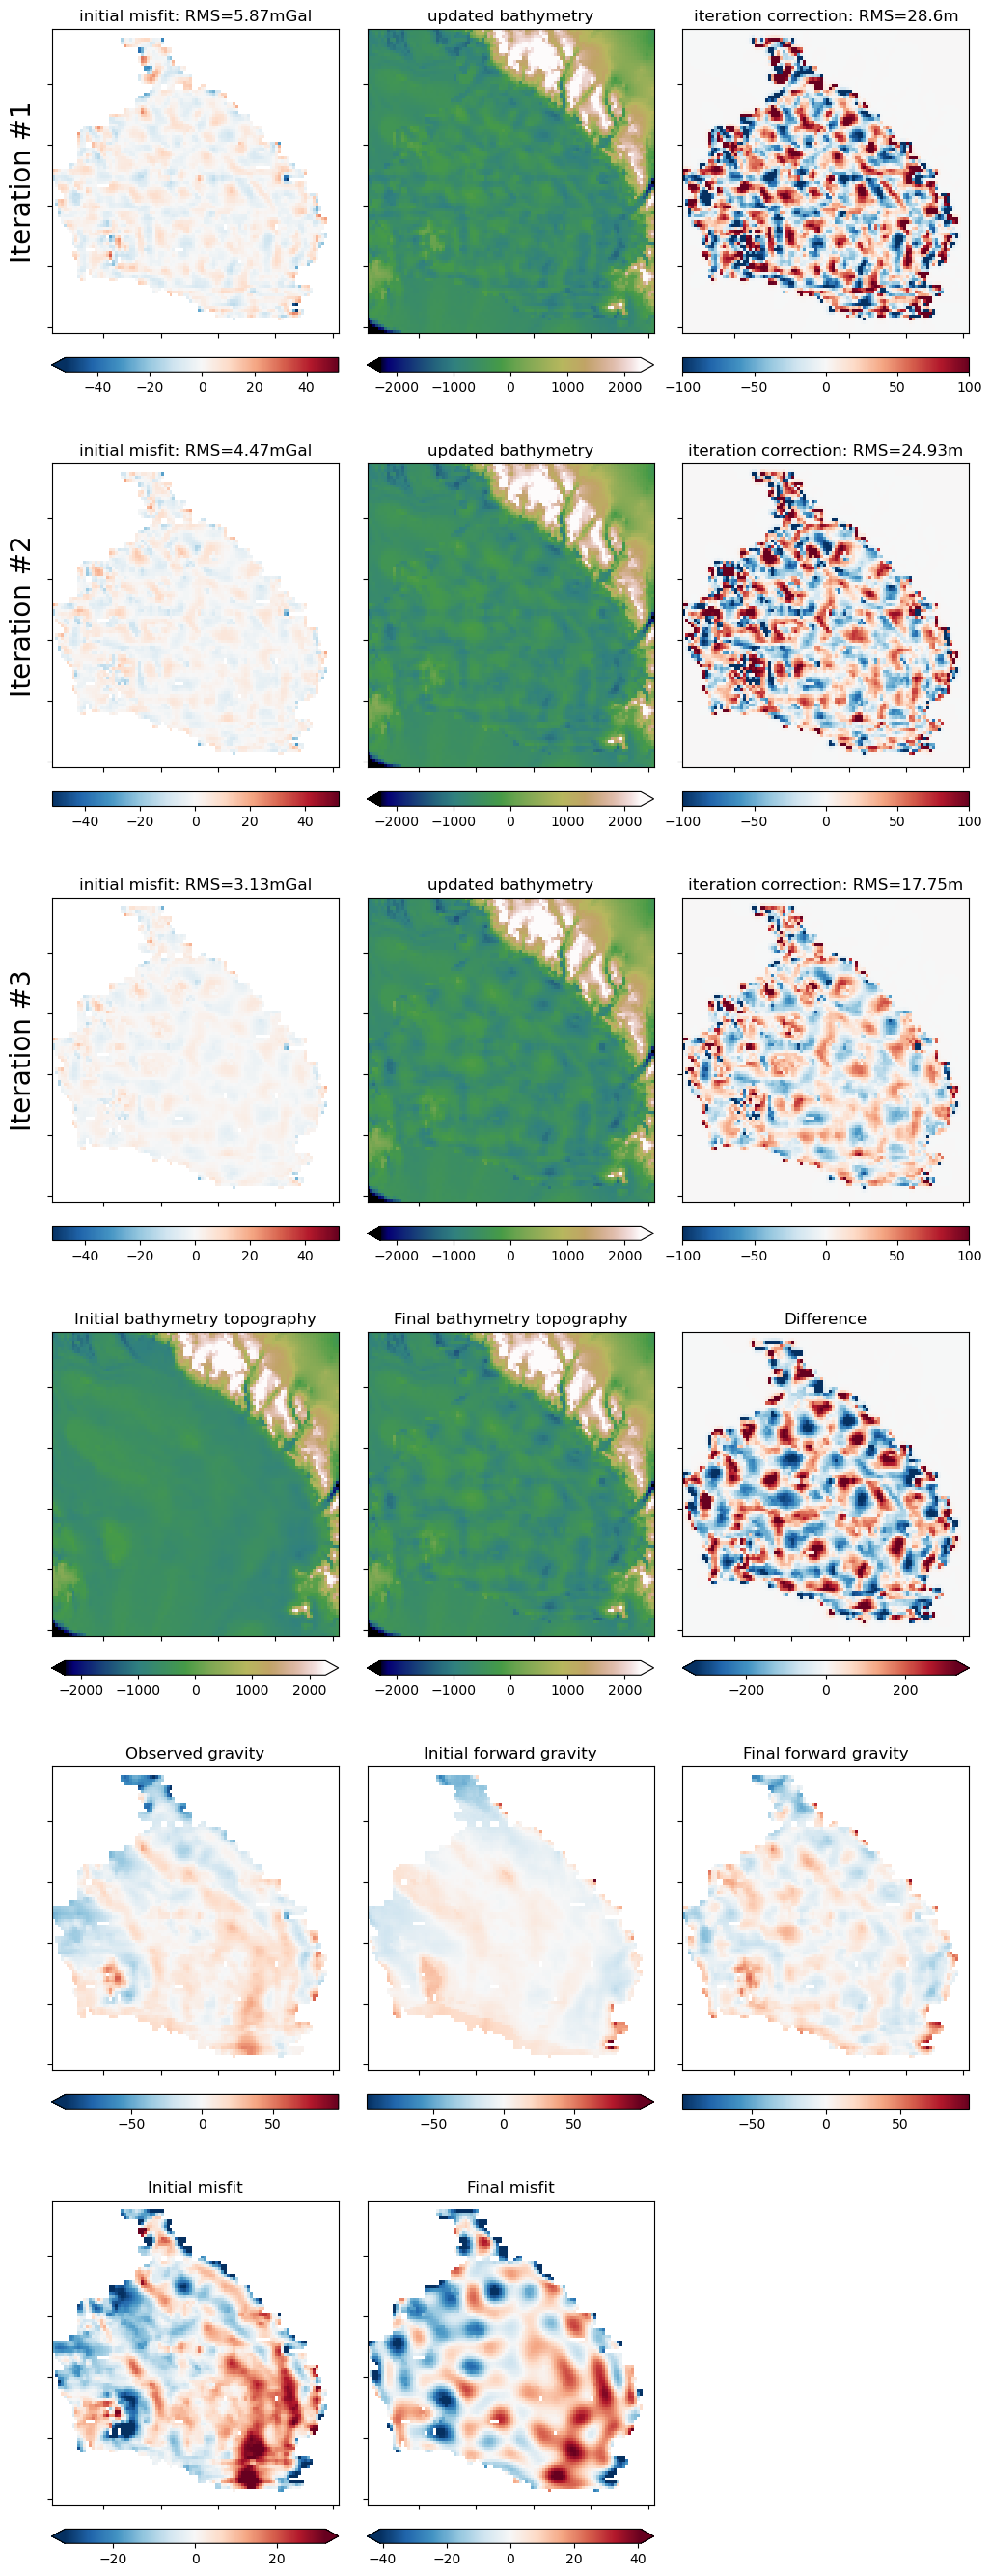

In [59]:
inv.plot_inversion_results(
    grav_results,
    # "results/gravity_results_5k_constraints_no_base.csv",
    topo_results,
    # "results/topo_results_5k_constraints_no_base.csv",
    layers,

    active_layer = 'bathymetry',
    grav_spacing = grav_spacing,
    epsg = 'epsg:3031',
    
    inversion_region = inv_reg,
    # plot_region = buffer_reg,
    plot_constraints = False,
    # constraints = constraints_RIS_df,
    
    save_topo_nc=True,
    topo_fname='inverted_topo_5k_constraints_no_base',

    save_residual_nc=True,
    residual_fname='initial_residual_5k_constraints_no_base',
)


In [ ]:
dif = utils.grd_compare(
    'results/initial_residual_5k_constraints_no_base.nc', 
    'results/initial_residual_5k_constraints_base.nc',
    robust = True,
    )

In [ ]:
dif = utils.grd_compare(
    'results/inverted_topo_5k_constraints_no_base.nc', 
    'results/inverted_topo_5k_constraints_base.nc',
    shp_mask = "plotting/MEaSUREs_RIS.shp")
    

In [ ]:
da1 = xr.load_dataarray("inversion_layers/bedmachine/BedMachine_bed.nc")
da2 = xr.load_dataarray('results/inverted_topo_5k_constraints_base.nc')

dif = utils.grd_compare(
    da1, 
    da2,
    shp_mask = "plotting/MEaSUREs_RIS.shp",
    )


In [ ]:
from ipyfastscape import TopoViz3d
ds2 = da2.to_dataset()

app = TopoViz3d(ds2, elevation_var='z')

app.show()

# Density inversion

In [ ]:
# density_inversion(
    # density_layer='bathymetry', 
    # plot=True
    # ) 
#10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify